In [1]:
import sympy
from mira.metamodel import *
from mira.modeling.amr.petrinet import template_model_to_petrinet_json_file

In [2]:
S = lambda: Concept(name='S', identifiers={'ido': '0000514'},
                    context={'species': 'ncbitaxon:9606'})
E = lambda: Concept(name='E', identifiers={'apollosv': '00000154'},
                    context={'species': 'ncbitaxon:9606'})
I = lambda: Concept(name='I', identifiers={'ido': '0000511'},
                    context={'species': 'ncbitaxon:9606'})
R = lambda: Concept(name='R', identifiers={'ido': '0000592'},
                    context={'species': 'ncbitaxon:9606'})

In [3]:
infection_rate = sympy.Symbol('alpha_se') * sympy.Symbol('beta') * \
    sympy.Symbol('S') * sympy.Symbol('I') / sympy.Symbol('N')
templates = [
    ControlledConversion(subject=S(), outcome=E(),
                         controller=I()).with_rate_law(infection_rate),
    NaturalConversion(subject=E(), outcome=I()).with_mass_action_rate_law('alpha_ei'),
    NaturalConversion(subject=I(), outcome=R()).with_mass_action_rate_law('tau'),
]
N = 96_862_500
parameters = {
    'alpha_se': 0.01,
    'alpha_ei': 1/8.5,
    'tau': 1/8,
    'beta': 0.34,
    'N': 96_862_500,
}
params = {k: Parameter(name=k, value=v) for k, v in parameters.items()}
initials = {'S': Initial(concept=S(), expression=SympyExprStr(sympy.Float(N))),
            'E': Initial(concept=E(), expression=SympyExprStr(sympy.Float(0))),
            'I': Initial(concept=I(), expression=SympyExprStr(sympy.Float(0))),
            'R': Initial(concept=R(), expression=SympyExprStr(sympy.Float(0)))}

tm = TemplateModel(templates=templates, parameters=params,
                   initials=initials)

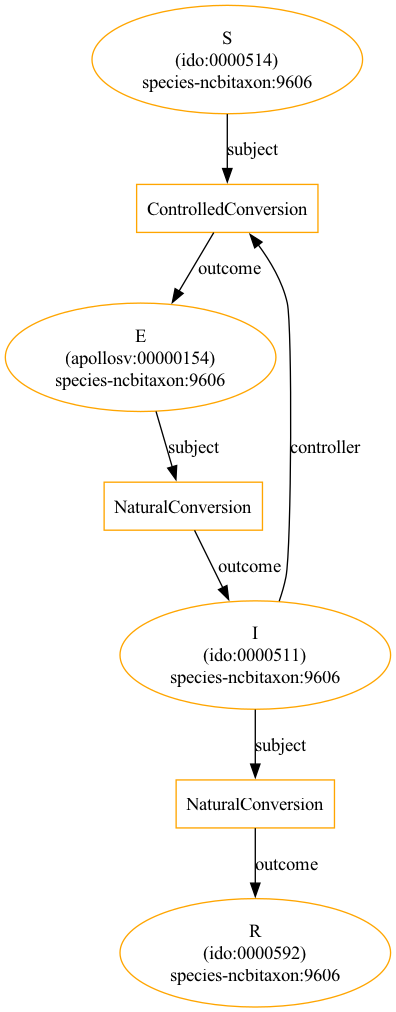

In [4]:
tm.draw_jupyter()

In [5]:
tm = stratify(
    tm,
    key='sex',
    strata=['m', 'w'],
    structure=[],
    cartesian_control=True,
    param_renaming_uses_strata_names=True
)

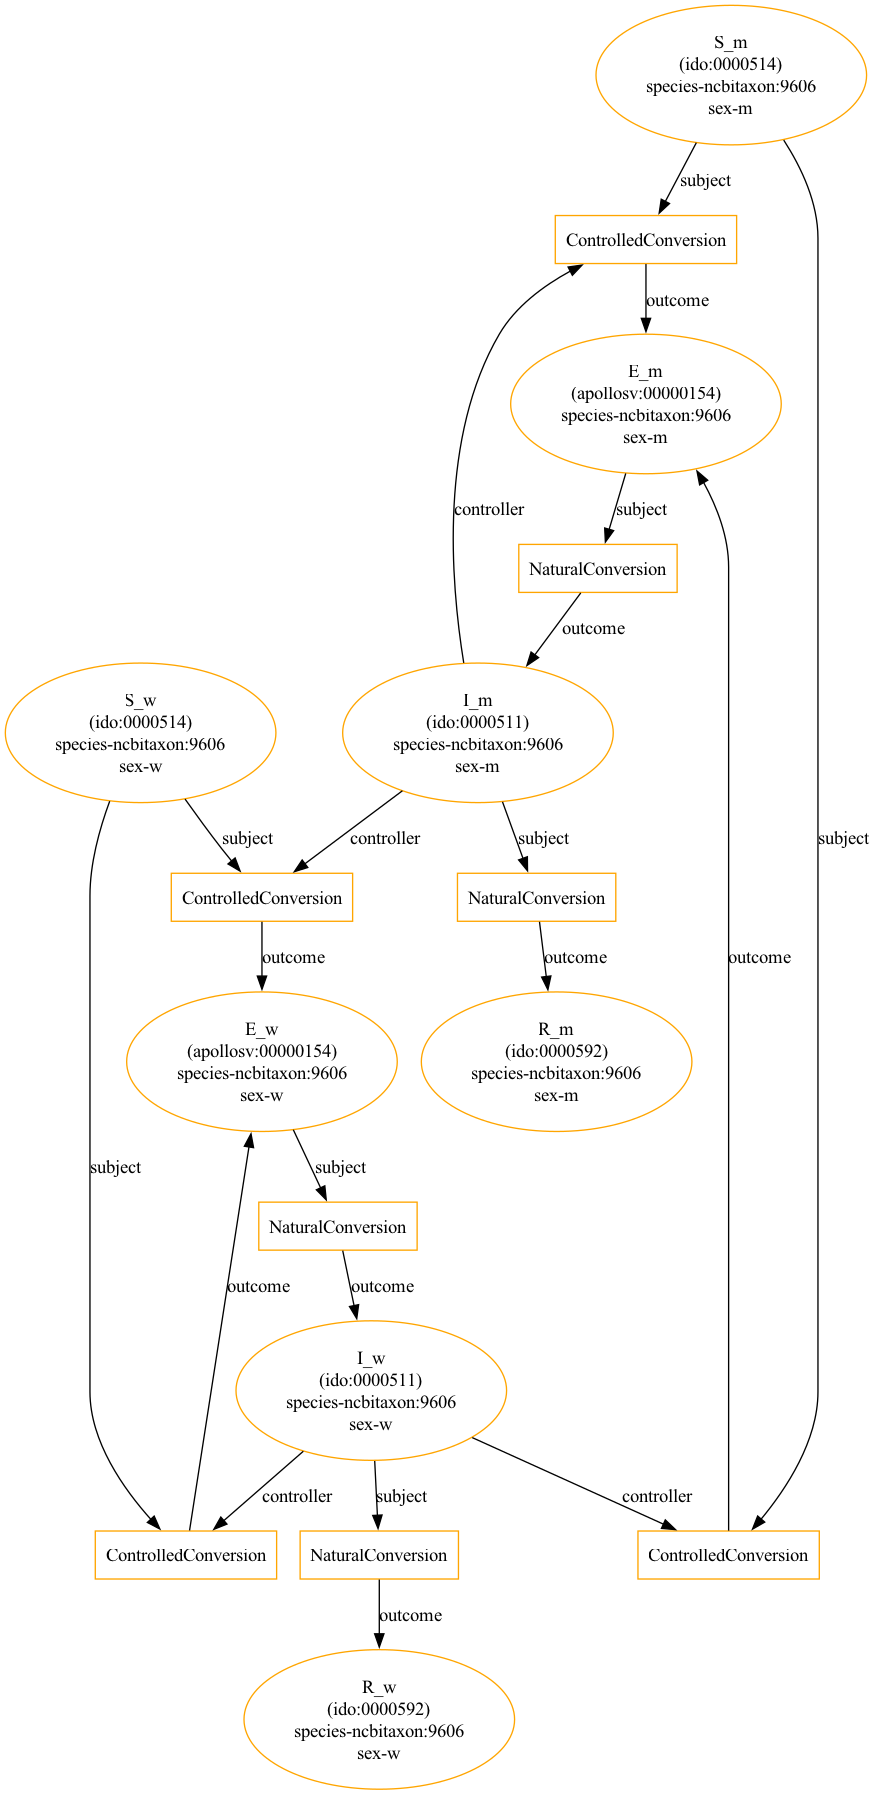

In [6]:
tm.draw_jupyter()

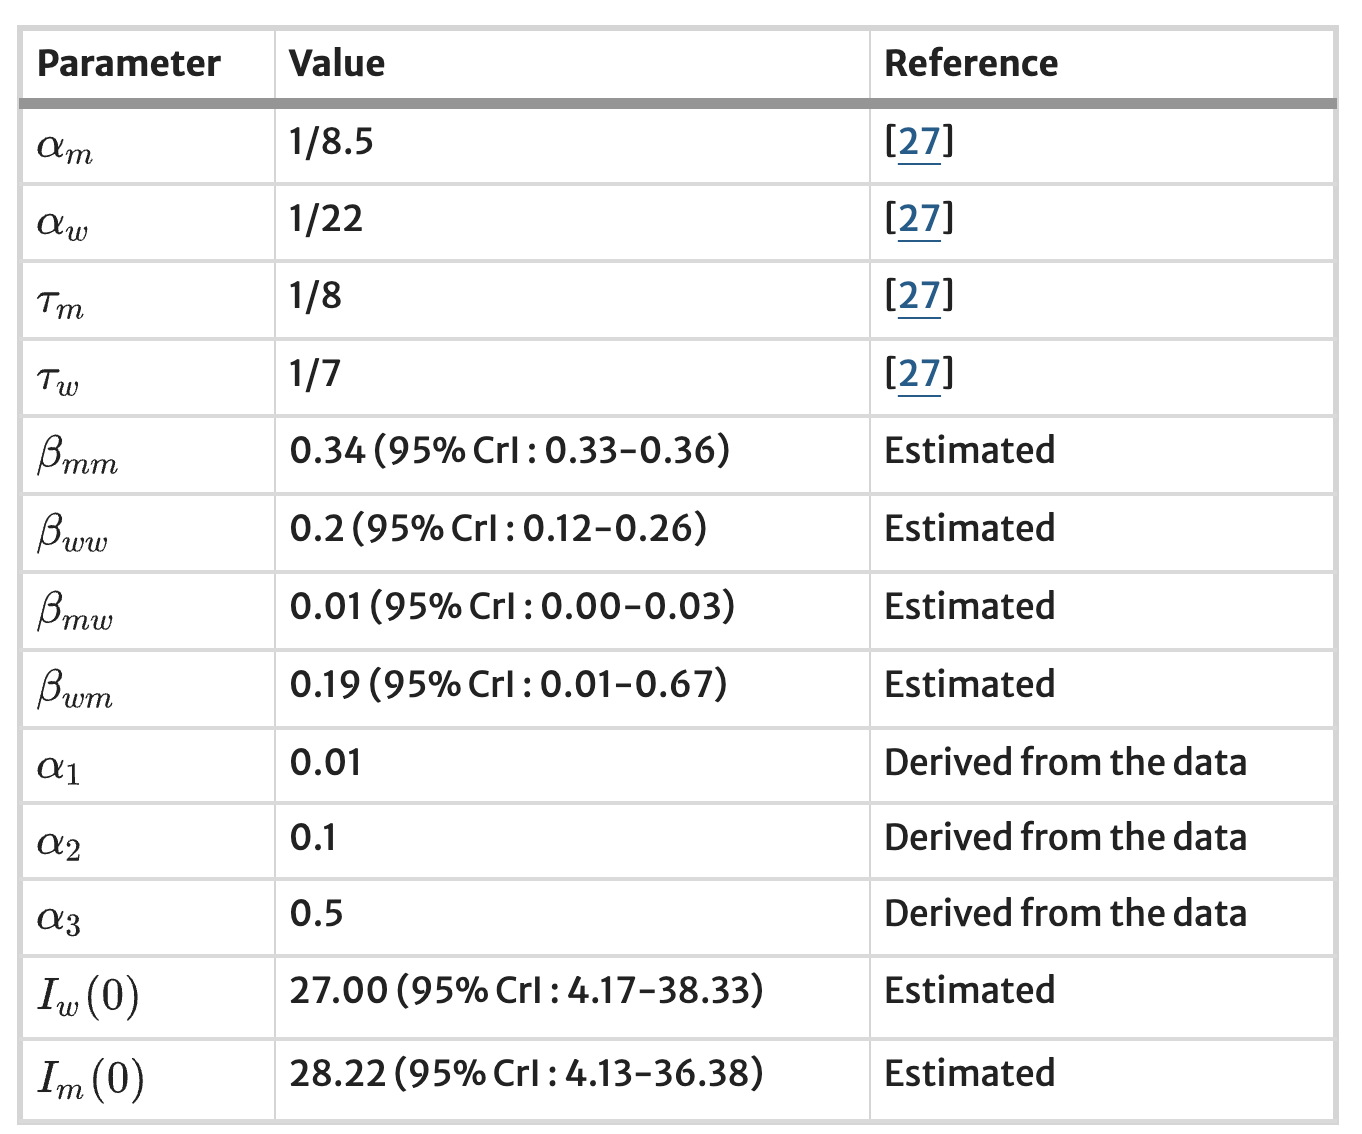

In [7]:
tm.set_parameters({
    'alpha_se_m_m': 1,
    'alpha_se_w_m': 0.01,
    'alpha_se_m_w': 0.1,
    'alpha_se_w_w': 0.5,
    'alpha_ei_m': 1/8.5,
    'alpha_ei_w': 1/22,
    'beta_m_m': 0.34,
    'beta_w_m': 0.19,
    'beta_m_w': 0.01,
    'beta_w_w': 0.2,
    'tau_m': 1/8,
    'tau_w': 1/7
})

In [8]:
tm.set_initials({
    'S_m': SympyExprStr(sympy.Float(N-28.22)),
    'I_m': SympyExprStr(sympy.Float(28.22)),
    'S_w': SympyExprStr(sympy.Float(N-27)),
    'I_w': SympyExprStr(sympy.Float(27))
})

In [9]:
tm.observables = {
    'cases_m': Observable(name='cases_m', expression=sympy.parse_expr('alpha_ei_m*E_m')),
    'cases_w': Observable(name='cases_w', expression=sympy.parse_expr('alpha_ei_w*E_w'))
}

In [10]:
import numpy
from mira.modeling import Model
from mira.modeling.ode import OdeModel

om = OdeModel(Model(tm), initialized=True)
times = numpy.linspace(0, 30, 100)

res = om.simulate_model(times, with_observables=True)

In [11]:
om.get_interpretable_kinetics()

Matrix([
[Derivative(S_m, t), =,                          -3.51013033939863e-9*I_m*S_m - 1.03239127629372e-11*I_w*S_m],
[Derivative(I_m, t), =,                                                    0.117647058823529*E_m - 0.125*I_m],
[Derivative(E_m, t), =,  -0.117647058823529*E_m + 3.51013033939863e-9*I_m*S_m + 1.03239127629372e-11*I_w*S_m],
[Derivative(I_w, t), =,                                       0.0454545454545455*E_w - 0.142857142857143*I_w],
[Derivative(S_w, t), =,                          -1.96154342495806e-11*I_m*S_w - 1.03239127629372e-9*I_w*S_w],
[Derivative(E_w, t), =, -0.0454545454545455*E_w + 1.96154342495806e-11*I_m*S_w + 1.03239127629372e-9*I_w*S_w],
[Derivative(R_m, t), =,                                                                            0.125*I_m],
[Derivative(R_w, t), =,                                                                0.142857142857143*I_w]])

In [12]:
om.get_interpretable_observables()

Matrix([
[cases_m, =,  0.117647058823529*E_m],
[cases_w, =, 0.0454545454545455*E_w]])

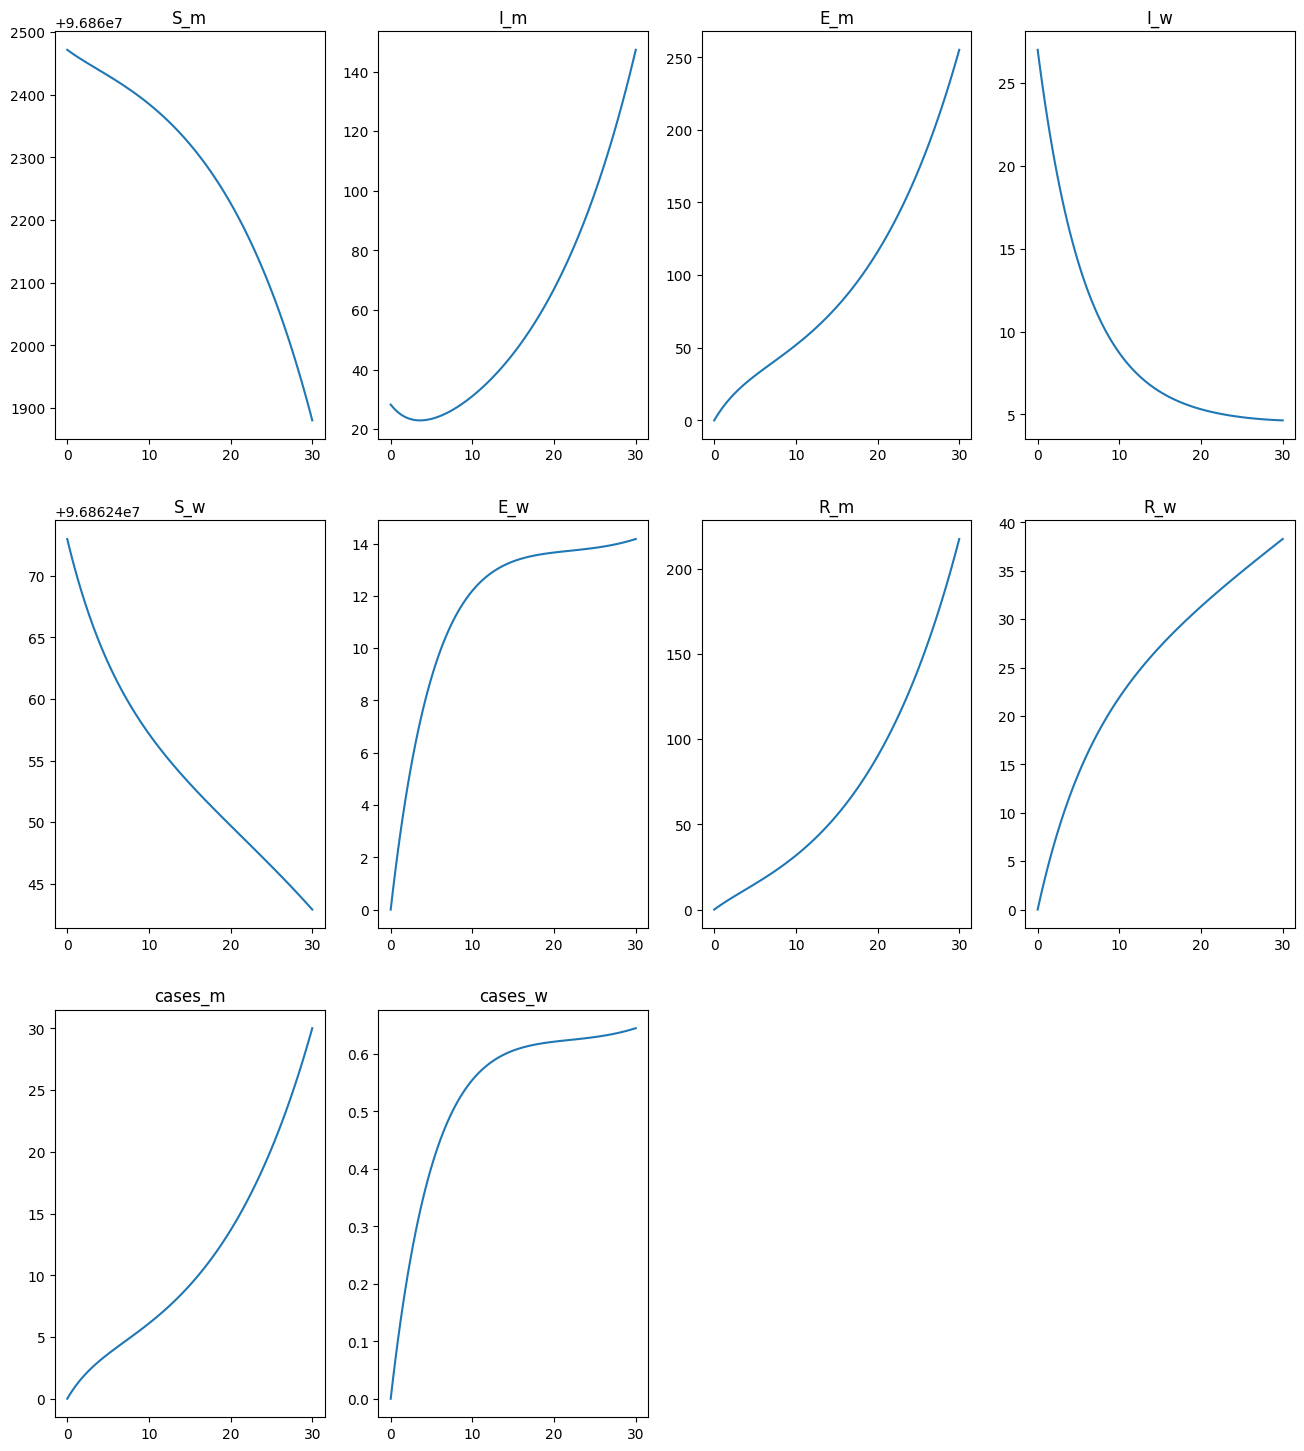

In [13]:
om.plot_simulation_results(times, res)

In [14]:
template_model_to_petrinet_json_file(tm, 'ModelC_base_petri.json')